ToDo:
Add category identifiers and constraingts, so that servings of spices or servings of animal products, etc are within bounds.

###### Imports & Data loading

In [1]:
import pandas as pd
from pulp import LpProblem, LpVariable, lpSum, LpMinimize, LpAffineExpression, \
LpConstraint, PULP_CBC_CMD
import numpy as np
import pulp as plp
import seaborn as sns
from notebooks_module.linear_programming import CorrelationCutoff,\
formulateMP, checkFeasibility, infeasibilitySearch

In [2]:
import importlib
import notebooks_module.linear_programming

In [3]:
importlib.reload(notebooks_module.linear_programming)

<module 'notebooks_module.linear_programming' from '/Users/williammohr/DataScience/portfolio/Nutrition/03_Notebooks/notebooks_module/linear_programming.py'>

In [4]:
foods = pd.read_csv('../02_Data_formatted/nv_df.csv', index_col='Unnamed: 0')
constraints = pd.read_csv('../02_Data_formatted/constraints.csv', 
index_col = 'Unnamed: 0')

In [5]:
# identify amino acids
amino_acids = CorrelationCutoff(foods.corr()['phenylalanine_tyrosine'],.9)
amino_acids = [aa for aa in amino_acids if aa != 'protein']
# curate the constraints list: chloride provided by salt, 
# cholesterol guidelines are particular to each person,
# vitamin b12 is easily and safely supplemented
constraints.drop(index = [
    # 'fat_total','carbohydrates','protein',  'calories',
    'cholesterol','chloride','vitamin_b12'], inplace = True)

In [6]:
# Adjust amino acid requirements for bodyweight
usr_mass = input("How many kilos do you weigh?")
usr_mass = int(usr_mass)
constraints.loc[amino_acids,'min'] *= usr_mass

How many kilos do you weigh? 77


In [7]:
# categorize constraints for exclusions from mathematical model
spices = foods[foods.calories<=15]
foods_substantial = foods.loc[[food for food in foods.index.values if 
                   food not in spices.index],:]

In [8]:
# Adjust constraint values
constraints.loc['fat_total','min']=0
# constraints.loc['protein','min']=0
constraints.loc['chloride','max']=3100
constraints.loc['biotin','min'] = 40
constraints.loc['sodium','min'] = 0
constraints.loc['calories','min']=0
constraints.loc['carbohydrates','min']=0
constraints.loc['calcium','min']=0


In [9]:
servings_contraints = pd.DataFrame(columns = ['min','max'], index = foods.index)
servings_contraints.loc[:,['min','max']] = [0,3]

In [10]:
#  servings_contraints.loc['broccoli_chopped_cooked','min'] = 1
#  servings_contraints.loc['cauliflower_cooked','min'] = 1
#  servings_contraints.loc['carrots_sliced_raw','min'] = 1
# servings_contraints.loc['mushrooms_shiitake_cooked','min'] = 1
# servings_contraints.loc['olive_oil_cold_pressed_extra_virgin','min'] = 1
# # servings_contraints.loc['olives_black_canned','min'] = 1
# servings_contraints.loc['blueberries_fresh','min'] = 0
# servings_contraints.loc['oranges_fresh','min'] = 1
# servings_contraints.loc['garbanzo_beans_cooked','min'] = 1
# servings_contraints.loc['tempeh_cooked','min'] = 2
# servings_contraints.loc['kale_cooked','min'] = 1
# servings_contraints.loc['eggs_pasture_raised_large_hard_boiled','max'] = 0
# servings_contraints.loc['salmon_wild_coho_broiled','min'] = 1
 # servings_contraints.loc['bell_peppers_sliced_red_raw','min'] = 1

In [11]:
lp_formulation = formulateMP(foods,constraints,servings_contraints,integer=False)
lp_formulation.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/williammohr/opt/anaconda3/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7q/63cgxnn50sl5zwxkchv_j2cr0000gn/T/c6afbf5fcdb0450296493762033eb983-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7q/63cgxnn50sl5zwxkchv_j2cr0000gn/T/c6afbf5fcdb0450296493762033eb983-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 64 COLUMNS
At line 6116 RHS
At line 6176 BOUNDS
At line 6302 ENDATA
Problem MODEL has 59 rows, 117 columns and 5934 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 36 (-23) rows, 116 (-1) columns and 3519 (-2415) elements
0  Obj 952.14 Primal inf 421.60753 (17)
7  Obj 1345.8291
Optimal - objective value 1345.8291
After Postsolve, objective 1345.8291, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 1345.82915 - 7 iterations time 0.002, Preso

1

###### What do the loadings look like for the solution with the infeasible constraints removed?

###### Investigating failed constraints

In [13]:
# nutrient_total = pd.Series(data = [0]*foods.shape[1], index = foods.columns)
# for food, srv in food_srv_dict.items():
#     foods.loc[food,:]
#     nutrient_total += foods.loc[food,:]*srv
# nutrient_total

NameError: name 'food_srv_dict' is not defined

In [ ]:
# nutrient_total.loc[constraints.index]

In [14]:
def constraint_factors(nutrient_total, constraints):
    nutrient_total = nutrient_total.loc[constraints.index]
    constraint_factors = pd.DataFrame(
        {'total':nutrient_total.values,
         'min_factor':nutrient_total.values/constraints['min'],
         'max_factor':nutrient_total.values/constraints['max']}, 
         index = nutrient_total.index)
    return constraint_factors

In [ ]:
cf = constraint_factors(nutrient_total, constraints)

In [24]:
import matplotlib.pyplot as plt

In [67]:
def nutrient_contributions(food_servings,food_nutr_vals):
    """Args --> dict:food_servings
    DataFrame:food_nutr_vals
    For each nutrient determine the amount contributed by each food in the 
    meal/diet.  It is the servings of the food times the nutrient value per 
    serving of the food."""
    contributions = {}
    for nutrient in food_nutr_vals.columns:
        contributions[nutrient] = {}
        for food in food_servings.keys():
            contributions[nutrient][food] = food_servings[food]*\
            food_nutr_vals.loc[food,nutrient]
    return contributions
    

In [95]:
def diet_analytics(lp_formulation, foods, constraints):
    total_cals = 0
    food_servings = {}
    for v in lp_formulation.variables():
        total_cals += v.varValue*foods.at[v.name,'calories']
        food_servings[v.name] = v.varValue
    food_servings[v.name] = v.varValue
    # nonzero serving foods
    food_srv_dict = {food:srv for food,srv in food_servings.items() if srv != 0}
    nutrient_total = pd.Series(data=[0]*foods.shape[1], index=foods.columns)
    for food, srv in food_srv_dict.items():
        foods.loc[food,:]
        nutrient_total += foods.loc[food,:]*srv
    cf = constraint_factors(nutrient_total, constraints)

    # plot the factors of min, max constraint values for nutrients
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[20,10], 
                            layout='constrained')
    axs[0].set_yticks(range(len(cf.index)),cf.index)
    axs[0].set_title(
        'Multiple of Min Nutrient Val')
    axs[1].set_yticks(range(len(cf.index)), cf.index)
    axs[1].set_title(
        'Proportion of Max Nutrient Val')
    min_factors = [v if ~np.isinf(v) else 0 for v in cf.min_factor]
    max_factors = [v if ~np.isinf(v) else 0 for v in cf.max_factor]
    axs[0].barh(y=range(len(cf.index)), width = min_factors)
    axs[1].barh(y=range(len(cf.index)), width = max_factors)

    # plot the contributions for each nutrient by food
    ncols = int(len(cf.index)//(len(cf.index)**.5))
    nrows = int(ncols + np.ceil((len(cf.index)%ncols/ncols)))
    fig2, axs2 = plt.subplots(nrows=nrows, ncols=ncols, figsize=[100,100], 
                            layout='constrained')
    food_list = list(food_srv_dict.keys())
    n_foods = len(food_list)
    food_servings = food_srv_dict.values()
    nutrient_vals = nutrient_contributions(food_srv_dict, foods)
    
    for i, n in enumerate(np.asarray(cf.index)):
        axs2[i//ncols][i%ncols].bar(x=range(n_foods), 
                        height=[nutrient_vals[n][food] for food in food_list])
        axs2[i//ncols][i%ncols].set_xticks(range(n_foods), food_list, 
                                           rotation = 45)
        axs2[i//ncols][i%ncols].set_title(f'Nutrient Contributions by Food for {n}')
    return cf, fig, fig2

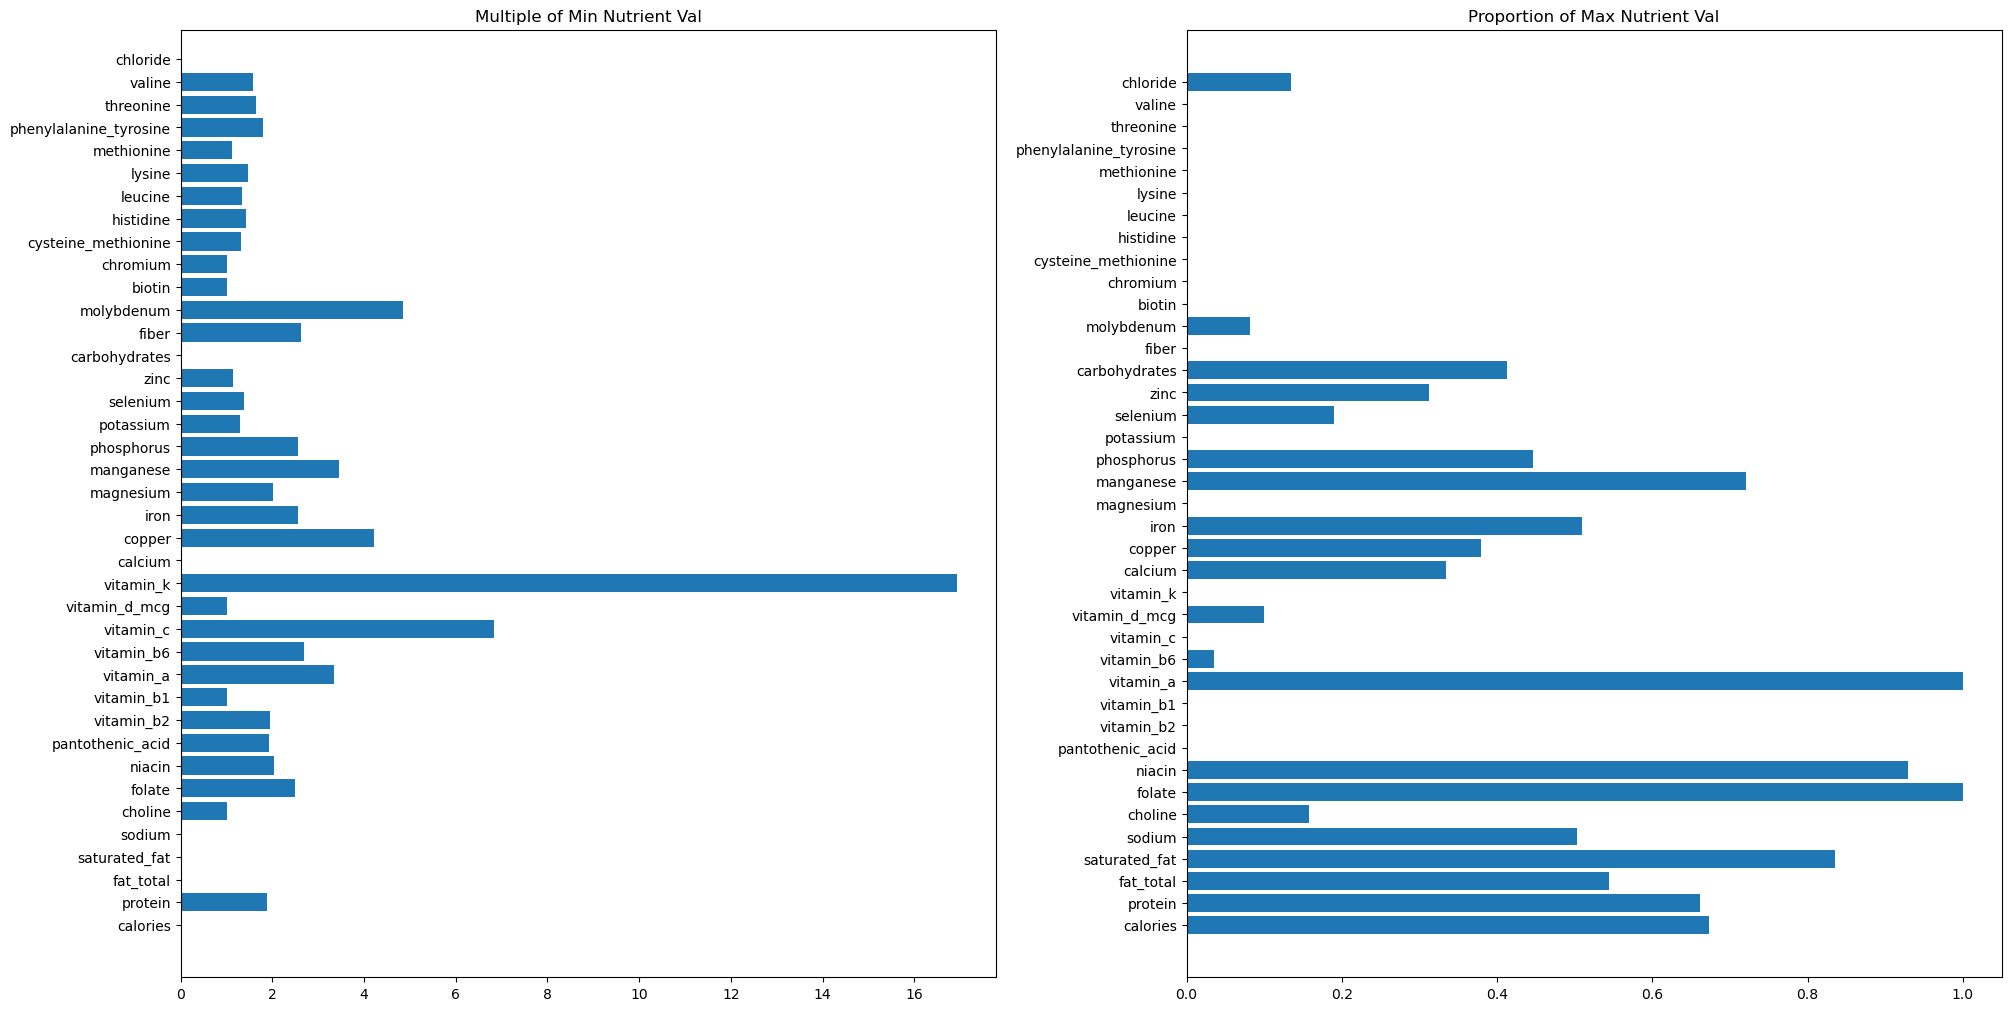

In [96]:
cf, fig, fig2 = diet_analytics(lp_formulation, foods, constraints)

In [97]:
fig2.savefig('./contributions.png')

###### Plot contribution breakdown by food type for each nutrient